# Cognitive Age Prediction with MRI and MEG

What else to do:

* run experiments so we will have the same subjects for MEG and MRI
* run profiling to get what takes most of the memory
* do stacking of fMRI and MEG, MRI and MEG as well, to check how they will behave together
* David will provide new MEG features based Rieman geometry and it should improve the performance

In [1]:
import dill
import pandas as pd
import mne
import numpy as np

from camcan.utils import (run_stacking, run_ridge, plot_pred, plot_learning_curve, plot_boxplot,
                          plot_barchart, plot_error_scatters, plot_error_age, plot_error_segments,
                          run_meg_ridge)

%matplotlib inline

/storage/tompouce/okozynet/miniconda3/envs/mne/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
CV = 10
N_JOBS = -1
# store mae, std for the summary plot
anatomy_mae = {}
function_mae = {}
meg_mae = {}
multimodal_mae = {}

anatomy_mae_std = {}
function_mae_std = {}
meg_mae_std = {}
multimodal_mae_std = {}

## Read Data

In [3]:
# read information about subjects
subjects_data = pd.read_csv('../../data/participant_data.csv', index_col=0)
# for storing predictors data
subjects_predictions = pd.DataFrame(subjects_data.age, index=subjects_data.index, dtype=float)

subjects_data.head()

,age,hand,gender_text,gender_code,tiv_cubicmm,cbuid700,cbuid280_sess1,cbuid280_sess2,cbuid280_sess3,cbuid280_sess4,profilecode,profilecode_numeric
Observations,,,,,,,,,,,,
CC110033,24,90.0,MALE,1,1413746.0,CBU120746,NaN,NaN,NaN,NaN,NaN,NaN
CC110037,18,89.0,MALE,1,1386581.0,CBU110544,NaN,NaN,NaN,NaN,NaN,NaN
CC110045,24,100.0,FEMALE,2,1385355.0,CBU111116,NaN,NaN,NaN,NaN,NaN,NaN
CC110056,22,100.0,FEMALE,2,1286849.0,CBU110547,NaN,CBU140153,CBU140224,NaN,D,1.0
CC110062,20,58.0,MALE,1,1582719.0,CBU110468,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# 643 subjects, each covariance is 9x306x306
meg_data = mne.externals.h5io.read_hdf5('../../data/covs_allch_oas.h5')
meg_subjects = {d['subject'] for d in meg_data if 'subject' in d}

print(f'Found {len(meg_data)} subjects')
print(f'A covarince matrix shape is {meg_data[0]["covs"].shape}')

Found 643 subjects
A covarince matrix shape is (9, 306, 306)


In [5]:
# read features

area_data = pd.read_hdf('../../data/structural/structural_data.h5', 
                           key='area')
thickness_data = pd.read_hdf('../../data/structural/structural_data.h5',
                               key='thickness')
volume_data = pd.read_hdf('../../data/structural/structural_data.h5',
                            key='volume')

area_data = area_data.dropna()
thickness_data = thickness_data.dropna()
volume_data = volume_data.dropna()

# take only subjects that are both in MEG and Structural MRI
structural_subjects = set(area_data.index)
common_subjects = meg_subjects.intersection(structural_subjects)

area_data = area_data.loc[common_subjects]
thickness_data = thickness_data.loc[common_subjects]
volume_data = volume_data.loc[common_subjects]

volume_data.head()

,Left-Lateral-Ventricle,Left-Inf-Lat-Vent,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus-Proper,Left-Caudate,Left-Putamen,Left-Pallidum,3rd-Ventricle,4th-Ventricle,...,SupraTentorialVol,SupraTentorialVolNotVent,SupraTentorialVolNotVentVox,MaskVol,BrainSegVol-to-eTIV,MaskVol-to-eTIV,lhSurfaceHoles,rhSurfaceHoles,SurfaceHoles,EstimatedTotalIntraCranialVol
Measure:volume,,,,,,,,,,,,,,,,,,,,,
CC410182,5169.2,251.2,14104.5,46229.8,7984.6,3113.9,4119.6,2017.3,706.6,1138.8,...,9.908301e+05,9.807711e+05,977507.0,1553376.0,0.767884,1.072427,24.0,22.0,46.0,1.448468e+06
CC510304,16035.1,322.4,14567.6,52353.4,7859.2,2446.1,3915.2,1678.8,1105.6,1547.1,...,1.046965e+06,1.021486e+06,1018767.0,1646397.0,0.711822,0.990143,43.0,40.0,83.0,1.662787e+06
CC721052,23350.8,988.9,13746.1,59932.1,7063.9,3643.2,4606.4,2052.6,1924.8,2309.8,...,9.915233e+05,9.471023e+05,944421.0,1698659.0,0.679862,1.010642,78.0,67.0,145.0,1.680771e+06
CC620436,40045.3,1589.3,12552.2,54089.6,7266.0,3477.3,4083.2,2010.6,2684.5,2787.8,...,9.800095e+05,9.042745e+05,902518.0,1711707.0,0.664845,1.015554,62.0,42.0,104.0,1.685490e+06
CC710350,19175.6,1096.3,16949.9,50887.6,6084.7,3683.2,4606.3,2095.1,1926.6,2698.0,...,1.037518e+06,9.979071e+05,994577.0,1709251.0,0.709442,1.025840,57.0,51.0,108.0,1.666196e+06


In [6]:
# read connectivity data
connect_data_tangent_basc = pd.read_hdf('../../data/connectivity/connect_data_tangent.h5',
                              key='basc197')
connect_data_r2z_basc = pd.read_hdf('../../data/connectivity/connect_data_correlation.h5',
                              key='basc197')
connect_data_tangent_modl = pd.read_hdf('../../data/connectivity/connect_data_tangent.h5',
                              key='modl256')
connect_data_r2z_modl = pd.read_hdf('../../data/connectivity/connect_data_correlation.h5',
                              key='modl256')
# use only common subjects
connect_data_tangent_basc = connect_data_tangent_basc.loc[common_subjects]
connect_data_r2z_basc = connect_data_r2z_basc.loc[common_subjects]
connect_data_tangent_modl = connect_data_tangent_modl.loc[common_subjects]
connect_data_r2z_modl = connect_data_r2z_modl.loc[common_subjects]

connect_data_tangent_basc.head()

,0,1,2,3,4,5,6,7,8,9,...,19493,19494,19495,19496,19497,19498,19499,19500,19501,19502
CC410182,-0.268917,-0.019755,-0.365641,0.059928,-0.062289,-0.486265,0.013103,0.017464,-0.063287,-0.437399,...,0.015899,0.030789,-0.039937,0.025537,0.055574,-0.011404,-0.045690,0.088216,-0.161145,-0.032296
CC510304,-0.046559,-0.090141,-0.118616,-0.053750,-0.055489,-0.296365,-0.212240,-0.174672,0.041573,-0.070247,...,-0.069469,0.003459,-0.009145,-0.060871,0.102281,0.018507,0.094864,0.038510,0.065775,-0.102496
CC721052,0.359675,-0.036926,0.380047,-0.084298,0.097372,0.176212,0.061910,-0.135258,-0.006784,0.408875,...,0.066852,-0.107258,0.051544,0.082192,0.005608,0.032371,-0.071305,0.081120,-0.057387,0.537562
CC620436,0.240239,-0.085374,0.060671,0.070610,-0.021539,0.245994,-0.039881,0.115425,-0.001356,0.158504,...,-0.062054,0.014376,0.103708,-0.051645,-0.030109,0.026865,0.179242,-0.007974,0.001522,0.187793
CC710350,0.633105,0.117848,0.249434,0.056396,-0.019890,0.266638,-0.040898,-0.031905,0.027148,0.398393,...,0.062612,-0.032743,-0.040836,-0.024847,-0.056781,0.003926,-0.025920,0.003389,0.002558,0.363414


## Structural MRI

### Training and Prediction

#### Area

MAE: 10.93
MAE STD: 0.81


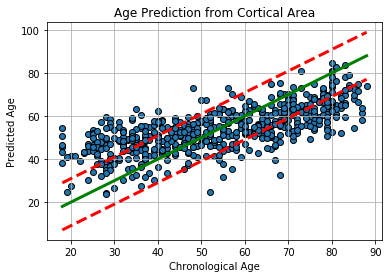

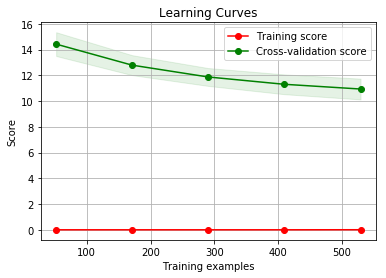

In [7]:
df_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores = \
    run_ridge(area_data, subjects_data, cv=CV, n_jobs=N_JOBS)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

anatomy_mae['Cortical Surface Area'] = arr_mae
anatomy_mae_std['Cortical Surface Area'] = (mae, std)
subjects_predictions.loc[df_pred.index, 'Cortical Surface Area'] = df_pred[0]

plot_pred(subjects_predictions.loc[df_pred.index].age,
          subjects_predictions.loc[df_pred.index, 'Cortical Surface Area'],
          mae, title='Age Prediction from Cortical Area')
plot_learning_curve(train_sizes, train_scores, test_scores)

#### Thickness

MAE: 7.67
MAE STD: 0.72


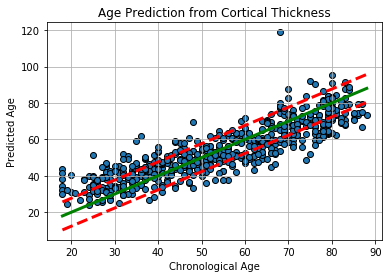

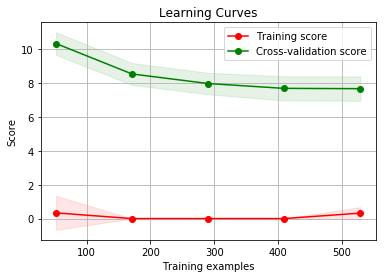

In [8]:
df_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores \
    = run_ridge(thickness_data, subjects_data, cv=CV, n_jobs=N_JOBS)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

anatomy_mae['Cortical Thickness'] = arr_mae
anatomy_mae_std['Cortical Thickness'] = (mae, std)
subjects_predictions.loc[df_pred.index, 'Cortical Thickness'] = df_pred[0]

plot_pred(subjects_predictions.loc[df_pred.index].age,
          subjects_predictions.loc[df_pred.index, 'Cortical Thickness'],
          mae, title='Age Prediction from Cortical Thickness')
plot_learning_curve(train_sizes, train_scores, test_scores)

#### Volume

MAE: 7.09
MAE STD: 0.83


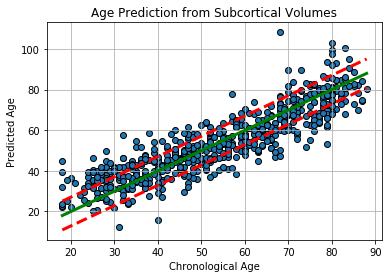

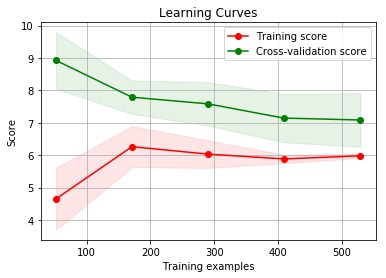

In [9]:
df_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores \
    = run_ridge(volume_data, subjects_data, cv=CV, n_jobs=N_JOBS)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

anatomy_mae['Subcortical Volumes'] = arr_mae
anatomy_mae_std['Subcortical Volumes'] = (mae, std)
subjects_predictions.loc[df_pred.index, 'Subcortical Volumes'] = df_pred[0]

plot_pred(subjects_predictions.loc[df_pred.index].age,
          subjects_predictions.loc[df_pred.index, 'Subcortical Volumes'],
          mae, title='Age Prediction from Subcortical Volumes')
plot_learning_curve(train_sizes, train_scores, test_scores)

## Functional MRI

### BASC 197

#### Tangent Space

MAE: 6.33
MAE STD: 0.70


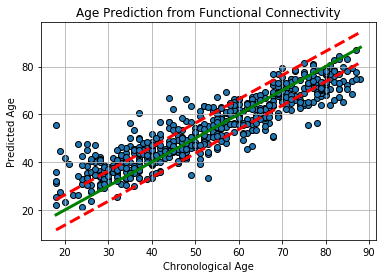

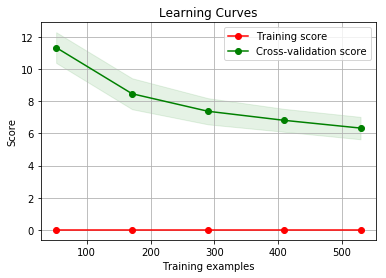

In [10]:
df_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores \
    = run_ridge(connect_data_tangent_basc, subjects_data, cv=CV, n_jobs=N_JOBS)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

function_mae_std['Connectivity Matrix, BASC 197 tan'] = (mae, std)
function_mae['Connectivity Matrix, BASC 197 tan'] = arr_mae
subjects_predictions.loc[df_pred.index, 'Connectivity Matrix, BASC 197 tan'] = df_pred[0]

plot_pred(subjects_predictions.loc[df_pred.index].age,
          subjects_predictions.loc[df_pred.index, 'Connectivity Matrix, BASC 197 tan'],
          mae, title='Age Prediction from Functional Connectivity')
plot_learning_curve(train_sizes, train_scores, test_scores)

#### Connectivity with Fisher's r-to-z Transform

MAE: 7.07
MAE STD: 0.69


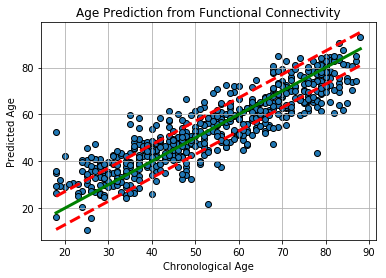

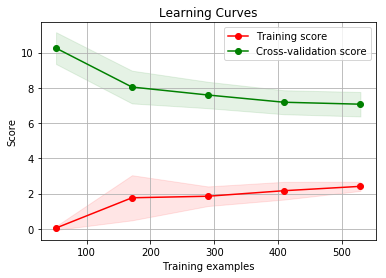

In [11]:
df_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores \
    = run_ridge(connect_data_r2z_basc, subjects_data, cv=CV, n_jobs=N_JOBS)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

function_mae_std['Connectivity Matrix, BASC 197 r2z'] = (mae, std)
function_mae['Connectivity Matrix, BASC 197 r2z'] = arr_mae
subjects_predictions.loc[df_pred.index, 'Connectivity Matrix, BASC 197 r2z'] = df_pred[0]

plot_pred(subjects_predictions.loc[df_pred.index].age,
          subjects_predictions.loc[df_pred.index, 'Connectivity Matrix, BASC 197 r2z'],
          mae, title='Age Prediction from Functional Connectivity')
plot_learning_curve(train_sizes, train_scores, test_scores)

### MODL 256

#### Tangent Space

MAE: 6.26
MAE STD: 0.72


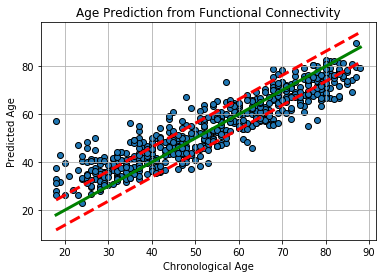

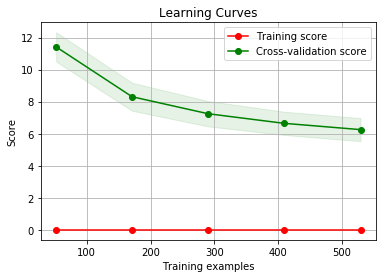

In [12]:
df_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores \
    = run_ridge(connect_data_tangent_modl, subjects_data, cv=CV, n_jobs=N_JOBS)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

function_mae_std['Connectivity Matrix, MODL 256 tan'] = (mae, std)
function_mae['Connectivity Matrix, MODL 256 tan'] = arr_mae
subjects_predictions.loc[df_pred.index, 'Connectivity Matrix, MODL 256 tan'] = df_pred[0]

plot_pred(subjects_predictions.loc[df_pred.index].age,
          subjects_predictions.loc[df_pred.index, 'Connectivity Matrix, MODL 256 tan'],
          mae, title='Age Prediction from Functional Connectivity')
plot_learning_curve(train_sizes, train_scores, test_scores)

#### Connectivity with Fisher's r-to-z Transform

MAE: 6.33
MAE STD: 0.76


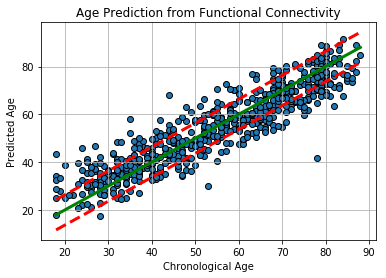

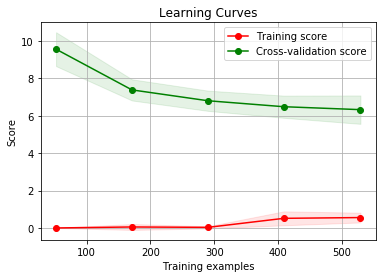

In [13]:
df_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores \
    = run_ridge(connect_data_r2z_modl, subjects_data, cv=CV, n_jobs=N_JOBS)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

function_mae_std['Connectivity Matrix, MODL 256 r2z'] = (mae, std)
function_mae['Connectivity Matrix, MODL 256 r2z'] = arr_mae
subjects_predictions.loc[df_pred.index, 'Connectivity Matrix, MODL 256 r2z'] = df_pred[0]

plot_pred(subjects_predictions.loc[df_pred.index].age,
          subjects_predictions.loc[df_pred.index, 'Connectivity Matrix, MODL 256 r2z'],
          mae, title='Age Prediction from Functional Connectivity')
plot_learning_curve(train_sizes, train_scores, test_scores)

## MEG

In [14]:
FREQ_BANDS = [(0.1, 1.5),  # low
              (1.5, 4.0),  # delta
              (4.0, 8.0),  # theta
              (8.0, 15.0),  # alpha
              (15.0, 26.0),  # beta_low
              (26.0, 35.0),  # beta_high
              (35.0, 50.0),  # gamma_low
              (50.0, 74.0),  # gamma_mid
              (76.0, 120.0)]  # gamma_high

Opening raw data file /home/parietal/okozynet/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Current compensation grade : 0
MAE: 9.22
MAE STD: 0.53


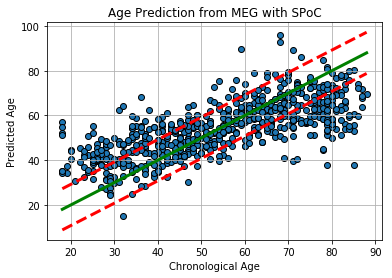

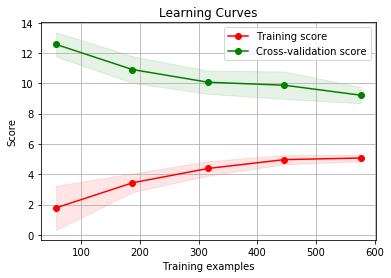

In [15]:
df_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores = \
    run_meg_ridge(meg_data, subjects_data, cv=CV, fbands=FREQ_BANDS)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

meg_mae['MEG'] = arr_mae
meg_mae_std['MEG'] = (mae, std)
subjects_predictions.loc[df_pred.index, 'MEG'] = df_pred[0]

plot_pred(subjects_predictions.loc[df_pred.index].age,
          subjects_predictions.loc[df_pred.index, 'MEG'],
          mae, title='Age Prediction from MEG with SPoC')
plot_learning_curve(train_sizes, train_scores, test_scores)

## Stacking

Parameters for stacking were taken from [Liem's paper](https://github.com/fliem/LeiCA_LIFE/blob/e9d02464a9e43b97cef9c7b753d88120cfbd6c94/learning/learning_stacking_utils.py#L30)

### Anatomy

MAE: 6.01
MAE STD: 0.41


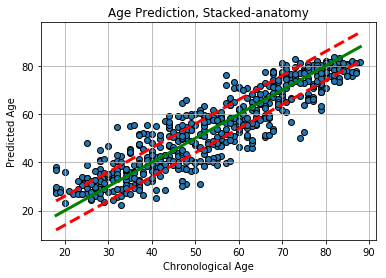

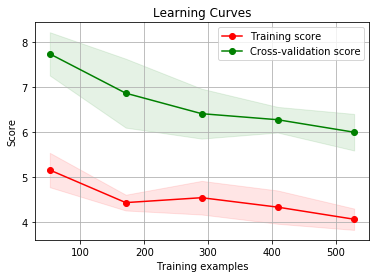

In [16]:
anatomy_data = [('area', area_data), ('thickness', thickness_data), ('volume', volume_data)]

df_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores \
    = run_stacking(anatomy_data, subjects_data, cv=CV)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

anatomy_mae_std['Stacked-anatomy'] = (mae, std)
anatomy_mae['Stacked-anatomy'] = arr_mae
subjects_predictions.loc[df_pred.index, 'Stacked-anatomy'] = df_pred[0]

plot_pred(subjects_predictions.loc[df_pred.index].age,
          subjects_predictions.loc[df_pred.index, 'Stacked-anatomy'],
          mae, title='Age Prediction, Stacked-anatomy')
plot_learning_curve(train_sizes, train_scores, test_scores)

### Connectivity

MAE: 6.09
MAE STD: 0.92


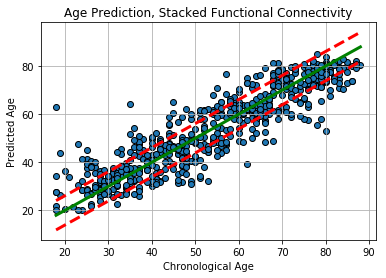

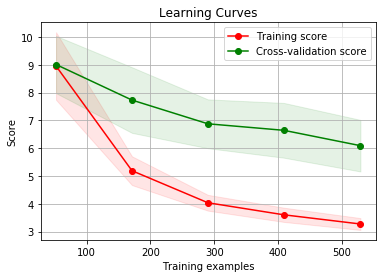

In [17]:
connect_data_tanh = [('basc', connect_data_tangent_basc), ('modl', connect_data_tangent_modl)]

df_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores \
    = run_stacking(connect_data_tanh, subjects_data, cv=CV)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

function_mae_std['Stacked-function'] = (mae, std)
function_mae['Stacked-function'] = arr_mae
subjects_predictions.loc[df_pred.index, 'Stacked-function'] = df_pred[0]

plot_pred(subjects_predictions.loc[df_pred.index].age,
          subjects_predictions.loc[df_pred.index, 'Stacked-function'],
          mae, title='Age Prediction, Stacked Functional Connectivity')
plot_learning_curve(train_sizes, train_scores, test_scores)

### MRI Multi-modal 

MAE: 5.10
MAE STD: 0.34


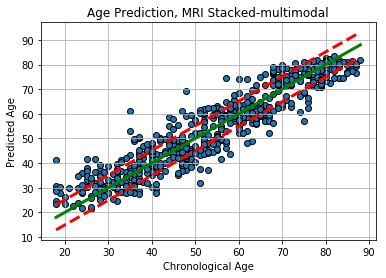

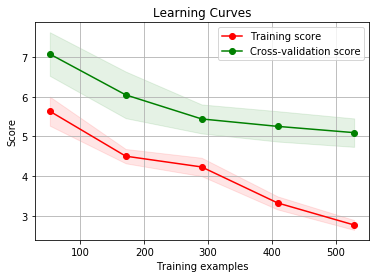

In [18]:
multimodal_data = [('area', area_data), ('thickness', thickness_data), ('volume', volume_data),
                   ('basc', connect_data_tangent_basc), ('modl', connect_data_tangent_modl)]

df_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores \
    = run_stacking(multimodal_data, subjects_data, cv=CV)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

multimodal_mae_std['MRI Stacked-multimodal'] = (mae, std)
multimodal_mae['MRI Stacked-multimodal'] = arr_mae
subjects_predictions.loc[df_pred.index, 'MRI Stacked-multimodal'] = df_pred[0]

plot_pred(subjects_predictions.loc[df_pred.index].age,
          subjects_predictions.loc[df_pred.index, 'MRI Stacked-multimodal'],
          mae, title='Age Prediction, MRI Stacked-multimodal')
plot_learning_curve(train_sizes, train_scores, test_scores)

### MEG with MRI Multi-modal

Opening raw data file /home/parietal/okozynet/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Current compensation grade : 0
MAE: 4.81
MAE STD: 0.38


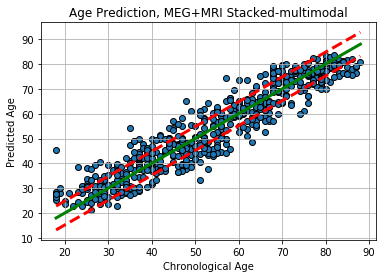

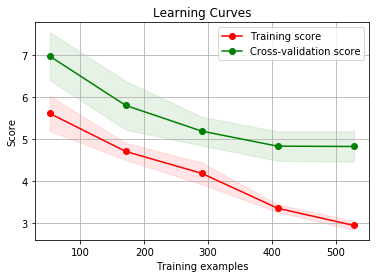

In [19]:
multimodal_data = [('area', area_data), ('thickness', thickness_data), ('volume', volume_data),
                   ('basc', connect_data_tangent_basc), ('modl', connect_data_tangent_modl),
                   ('meg', meg_data)]

df_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores \
    = run_stacking(multimodal_data, subjects_data, cv=CV, fbands=FREQ_BANDS)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

multimodal_mae_std['MEG+MRI Stacked-multimodal'] = (mae, std)
multimodal_mae['MEG+MRI Stacked-multimodal'] = arr_mae
subjects_predictions.loc[df_pred.index, 'MEG+MRI Stacked-multimodal'] = df_pred[0]

plot_pred(subjects_predictions.loc[df_pred.index].age,
          subjects_predictions.loc[df_pred.index, 'MEG+MRI Stacked-multimodal'],
          mae, title='Age Prediction, MEG+MRI Stacked-multimodal')
plot_learning_curve(train_sizes, train_scores, test_scores)

## Summary

### Results from Liem2016

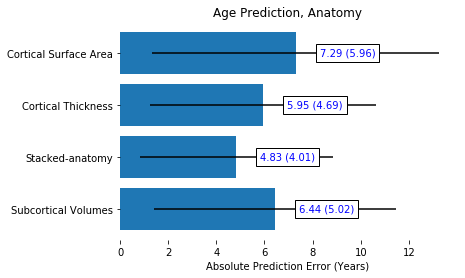

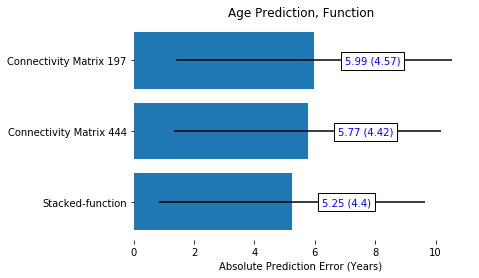

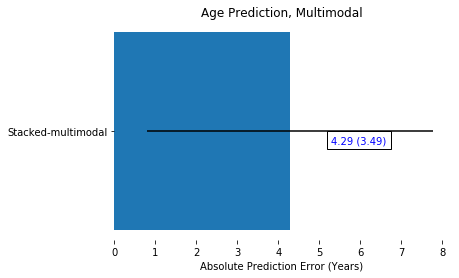

In [20]:
anatomy_mae_std_liem = {'Cortical Thickness': (5.95, 4.69),
                        'Cortical Surface Area': (7.29, 5.96),
                        'Subcortical Volumes': (6.44, 5.02),
                        'Stacked-anatomy': (4.83, 4.01)}

connect_mae_std_liem = {'Connectivity Matrix 197': (5.99, 4.57),
                        'Connectivity Matrix 444': (5.77, 4.42),
                        'Stacked-function': (5.25, 4.4)}

multimodal_mae_std_liem = {'Stacked-multimodal': (4.29, 3.49)}

plot_barchart(anatomy_mae_std_liem, title='Age Prediction, Anatomy', bar_text_indent=1)
plot_barchart(connect_mae_std_liem, title='Age Prediction, Function', bar_text_indent=1)
plot_barchart(multimodal_mae_std_liem, title='Age Prediction, Multimodal', bar_text_indent=1)

### Results for CamCAN

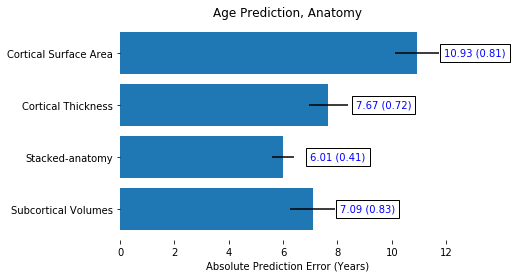

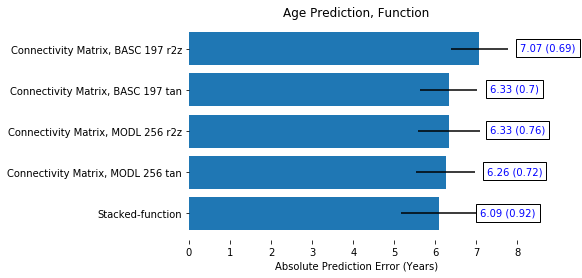

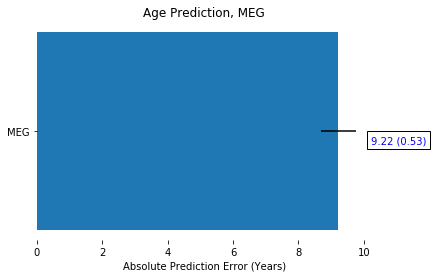

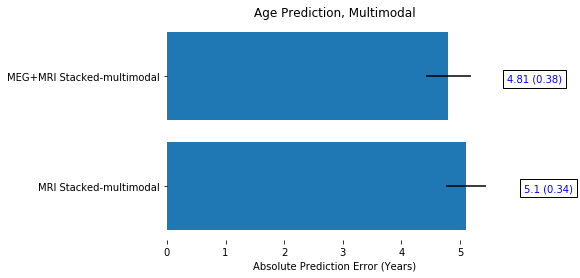

In [21]:
plot_barchart(anatomy_mae_std, title='Age Prediction, Anatomy', bar_text_indent=1)
plot_barchart(function_mae_std, title='Age Prediction, Function', bar_text_indent=1)
plot_barchart(meg_mae_std, title='Age Prediction, MEG', bar_text_indent=1)
plot_barchart(multimodal_mae_std, title='Age Prediction, Multimodal', bar_text_indent=1)

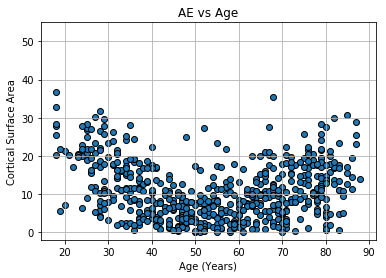

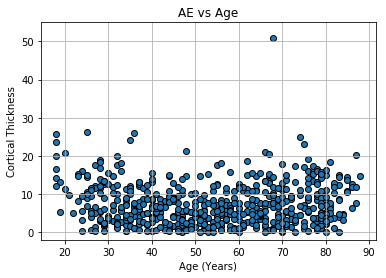

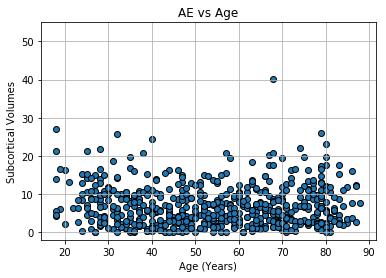

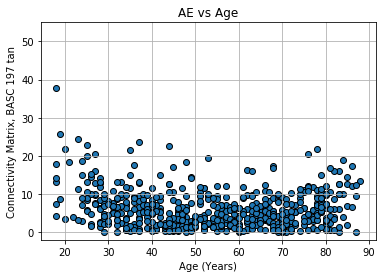

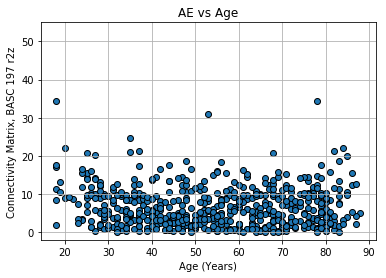

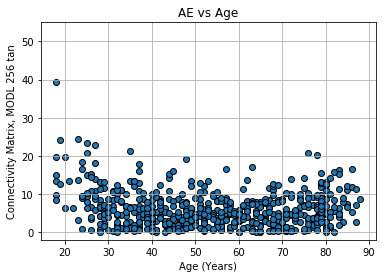

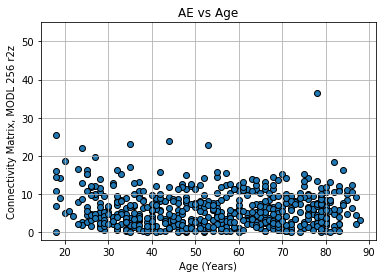

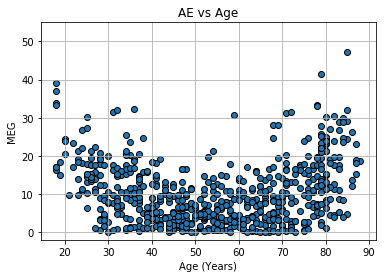

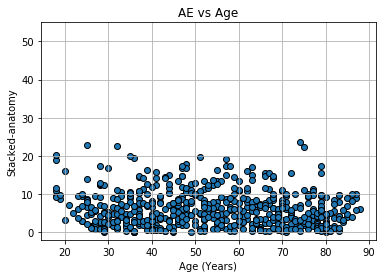

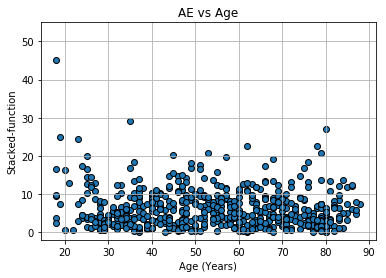

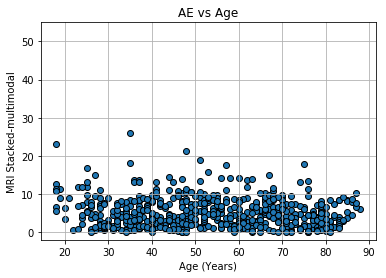

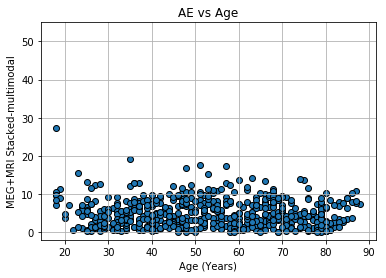

In [22]:
plot_error_age(subjects_predictions, ylim=(-2, 55))

/storage/tompouce/okozynet/miniconda3/envs/mne/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


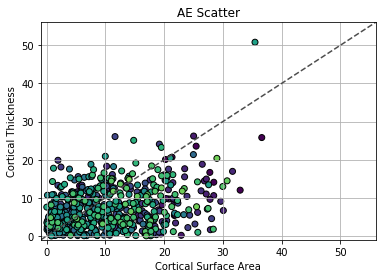

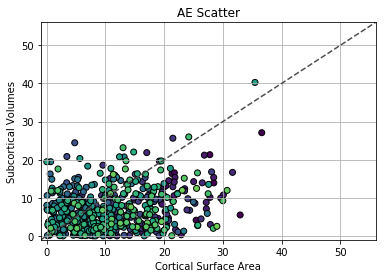

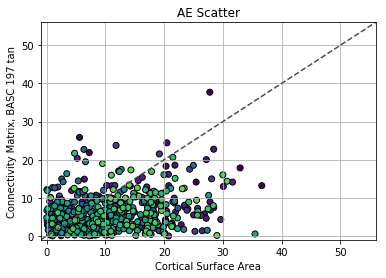

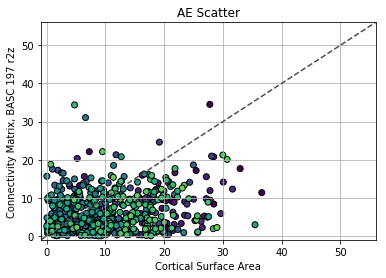

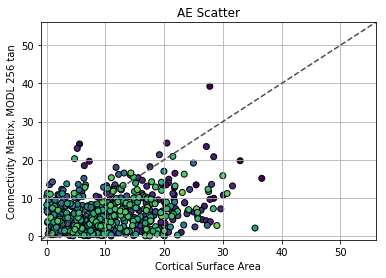

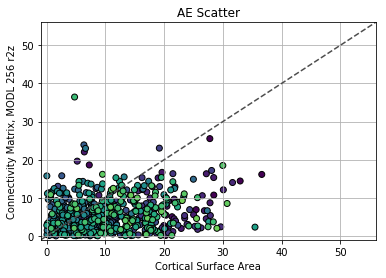

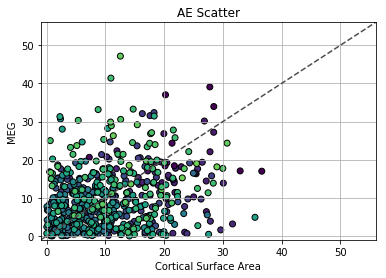

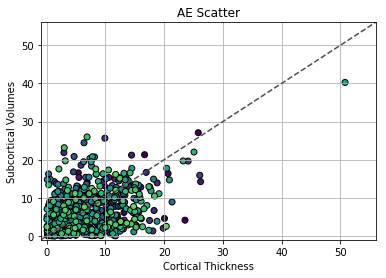

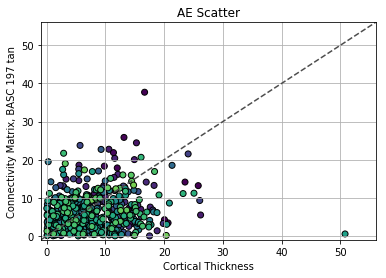

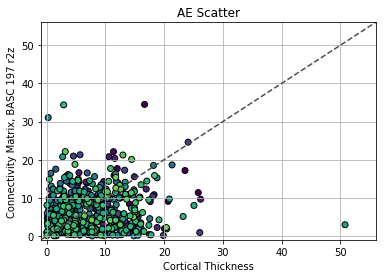

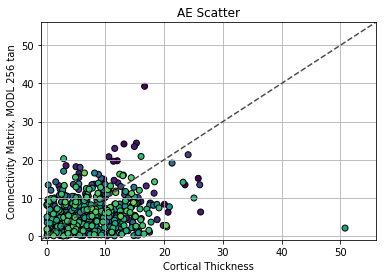

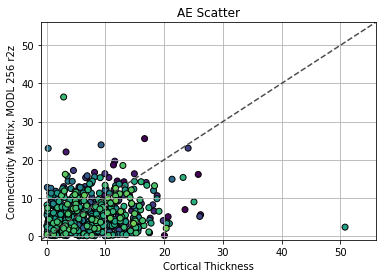

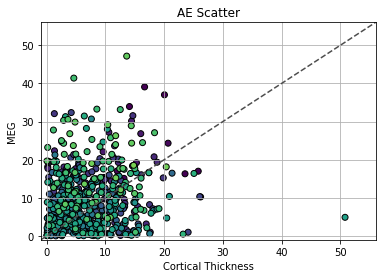

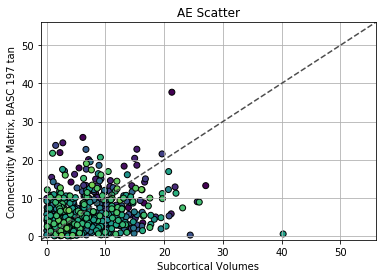

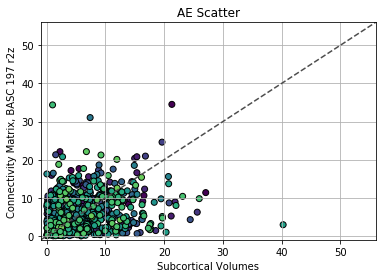

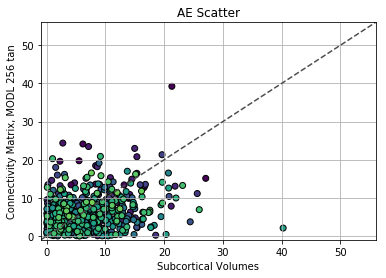

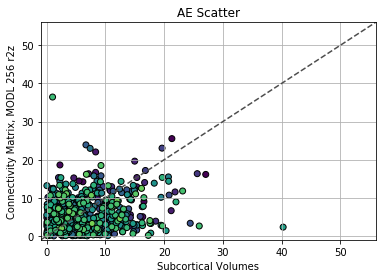

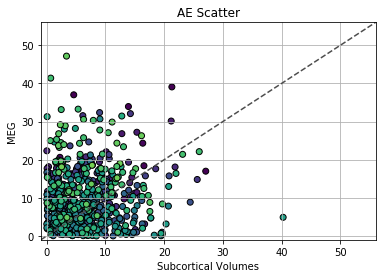

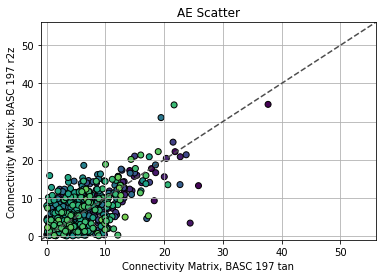

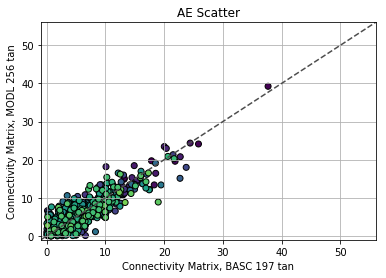

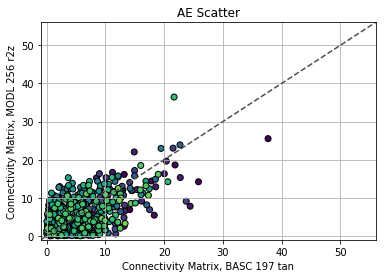

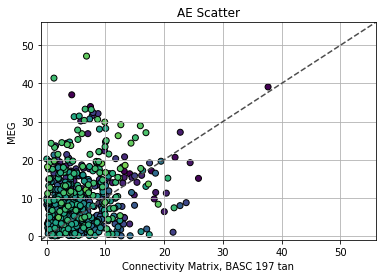

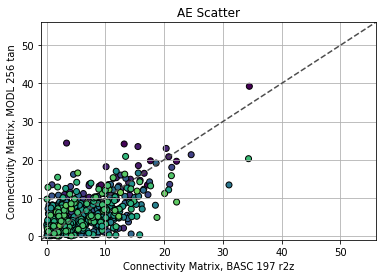

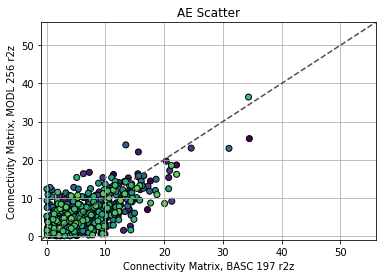

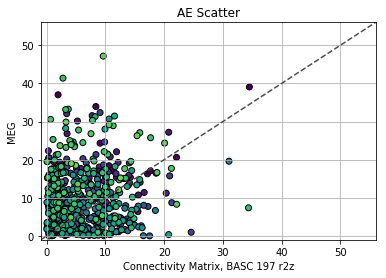

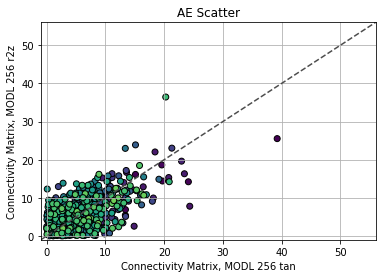

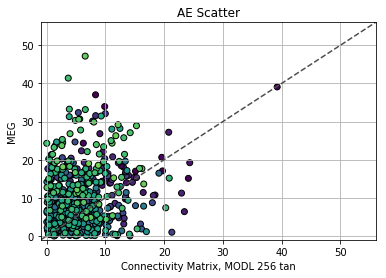

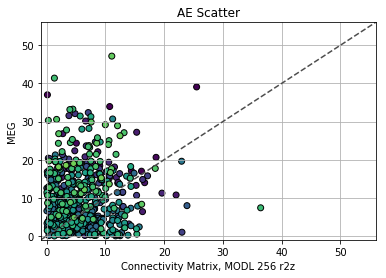

In [23]:
# drop results of stacked predictions
cols2drop = [c for c in subjects_predictions.columns if 'Stack' in c]
plot_error_scatters(subjects_predictions.drop(cols2drop, axis=1), xlim=(0, 55), ylim=(0, 55))

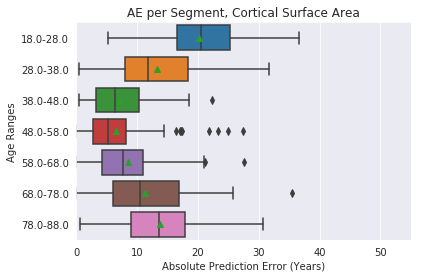

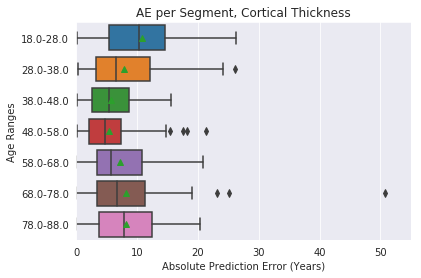

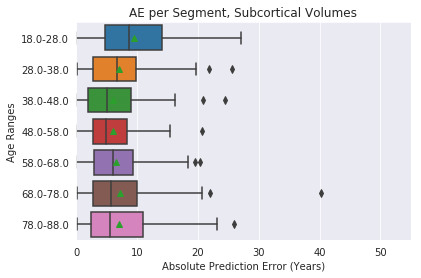

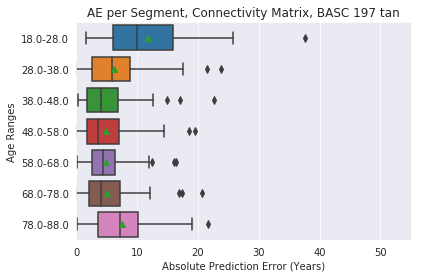

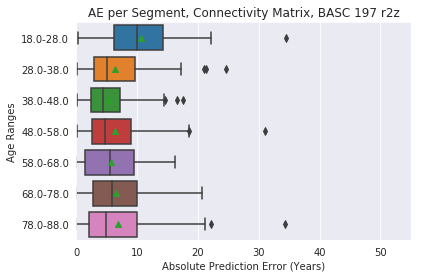

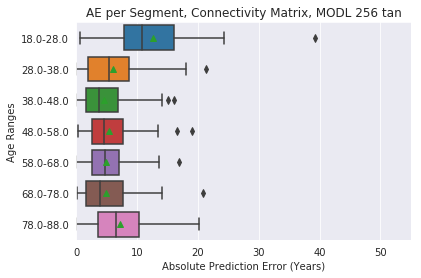

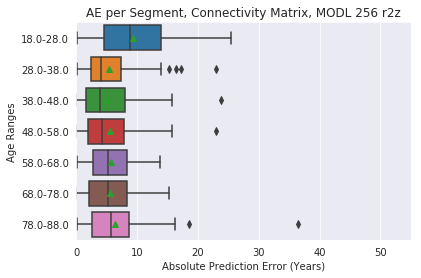

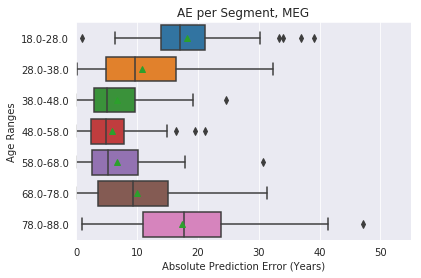

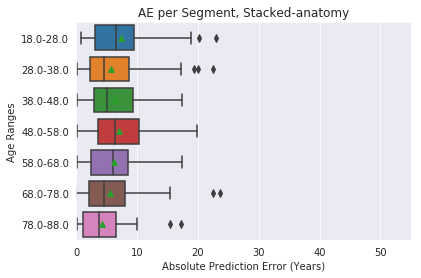

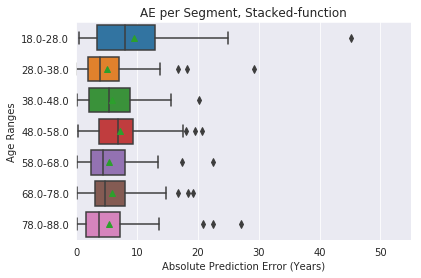

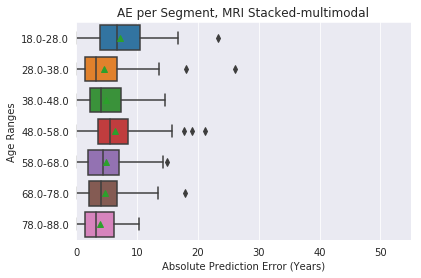

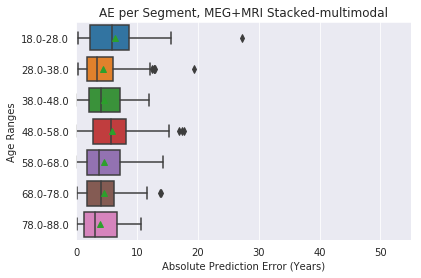

In [24]:
plot_error_segments(subjects_predictions, segment_len=10)

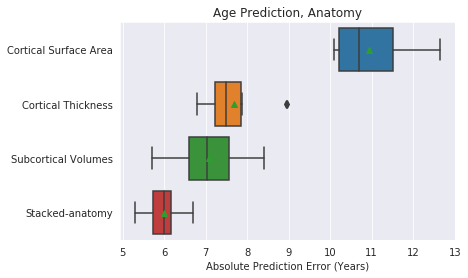

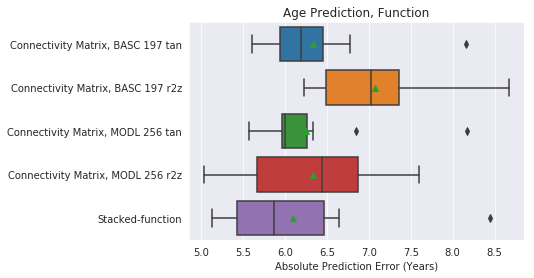

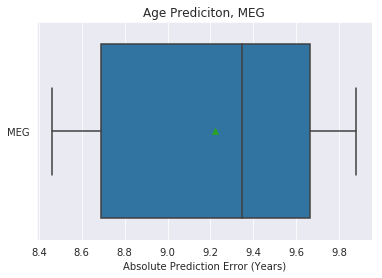

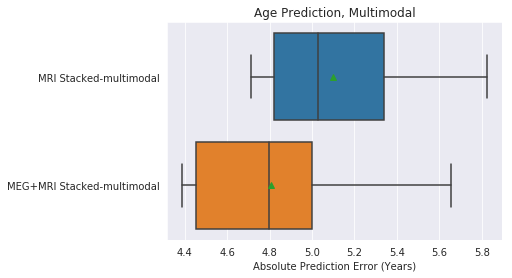

In [25]:
plot_boxplot(anatomy_mae, title='Age Prediction, Anatomy')
plot_boxplot(function_mae, title='Age Prediction, Function')
plot_boxplot(meg_mae, title='Age Prediciton, MEG')
plot_boxplot(multimodal_mae, title='Age Prediction, Multimodal')

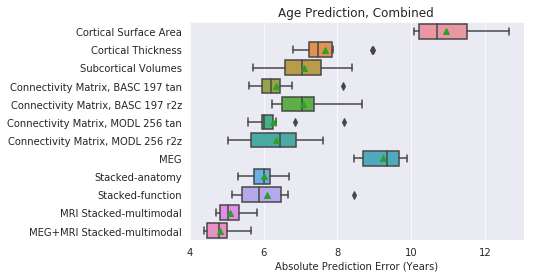

In [26]:
from collections import OrderedDict
from itertools import chain

it_chain = chain(anatomy_mae.items(), function_mae.items(), multimodal_mae.items(), meg_mae.items())

all_mae = OrderedDict((key, value) for key, value in it_chain if 'Stacked' not in key)

all_mae['Stacked-anatomy'] = anatomy_mae['Stacked-anatomy']
all_mae['Stacked-function'] = function_mae['Stacked-function']
all_mae['MRI Stacked-multimodal'] = multimodal_mae['MRI Stacked-multimodal']
all_mae['MEG+MRI Stacked-multimodal'] = multimodal_mae['MEG+MRI Stacked-multimodal']

plot_boxplot(all_mae, title='Age Prediction, Combined')

In [27]:
# dill.dump_session('../../data/ridgecv_azzaro.db')
# dill.load_session('../../data/ridgecv_azzaro.db')